In [ ]:
import openai
#openai.api_key = "not a key"


In [9]:
import openai
import json

# Load first 10 questions from test.jsonl
questions = []
with open("train_socratic.jsonl", "r") as f:
    for i, line in enumerate(f):
        if i >= 10:
            break
        data = json.loads(line)
        questions.append(data["question"])

# Prepare prompts with simple instruction
prompts = [f"{q}\nPlease only respond with the final answer." for q in questions]

# Run GPT-4o and collect responses
responses = []

for prompt in prompts:
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": prompt}
        ],
        max_tokens=20,
        temperature=0
    )
    answer = response.choices[0].message.content.strip()
    responses.append((prompt, answer))

# Save to file
with open("gpt4o_math_final_answers.txt", "w") as f:
    for prompt, answer in responses:
        f.write(f"{prompt}\nAnswer: {answer}\n\n")


In [ ]:

import json
import re

# Load first 10 question-answer pairs from test.jsonl
qa_pairs = []
with open("train_socratic.jsonl", "r") as f:
    for i, line in enumerate(f):
        if i >= 100:
            break
        data = json.loads(line)
        question = data["question"]
        answer_text = data["answer"]

        # Extract ground truth final answer (after ####)
        match = re.search(r'####\s*(.*)', answer_text)
        final_answer = match.group(1).strip() if match else "N/A"

        qa_pairs.append((question, final_answer))

# Build prompts
prompts = [f"🇸🇬 {q} 🇸🇬\nPlease only respond with the final answer." for q, _ in qa_pairs]
responses = []
for prompt in prompts:
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=20,
        temperature=0
    )
    gpt_answer = response.choices[0].message.content.strip()
    responses.append(gpt_answer)

# Write to file
with open("gpt4o_math_vs_ground_truth_singapore_fixed.txt", "w", encoding="utf-8") as f:
    for i in range(len(qa_pairs)):
        f.write(f"Question {i+1}:\n{qa_pairs[i][0]}\n")
        f.write(f"Prompt Sent:\n{prompts[i]}\n")
        f.write(f"✅ Ground Truth Answer: {qa_pairs[i][1]}\n")
        f.write(f"🤖 GPT-4o Answer: {responses[i]}\n")
        f.write("=" * 60 + "\n\n")

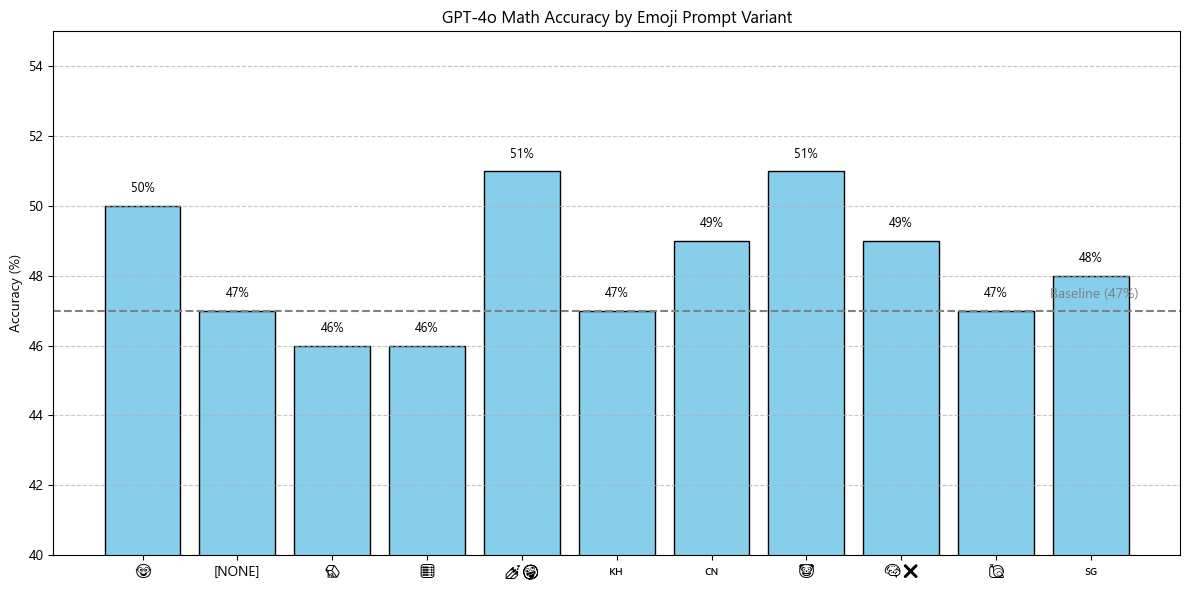

In [82]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Set emoji font
plt.rcParams['font.family'] = 'Segoe UI Emoji'
# Data: (Label, Accuracy)
data = [
    ("🤓", 50.00),
    ("[NONE]", 47.00),
    ("🪤", 46.00),
    ("🧮", 46.00),
    ("💅🤪", 51.00),
    ("🇰🇭", 47.00),
    ("🇨🇳", 49.00),
    ("🤡", 51.00),
    ("🧠❌", 49.00),
    ("🐌", 47.00),
    ("🇸🇬", 48.00)
]

# Split data
labels, accuracies = zip(*data)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, accuracies, color='skyblue', edgecolor='black')
baseline = 47.00
plt.axhline(y=baseline, color='gray', linestyle='--', linewidth=1.5)
plt.text(len(labels) - 0.5, baseline + 0.3, 'Baseline (47%)', color='gray', fontsize=10, ha='right', va='bottom')

# Labels and title
plt.title("GPT-4o Math Accuracy by Emoji Prompt Variant")
plt.ylabel("Accuracy (%)")
plt.ylim(40, 55)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show accuracy values above bars
for bar, val in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f"{val:.0f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [75]:
import re

number_words = {
    "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
    "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9,
    "ten": 10, "eleven": 11, "twelve": 12, "thirteen": 13,
    "fourteen": 14, "fifteen": 15, "sixteen": 16,
    "seventeen": 17, "eighteen": 18, "nineteen": 19,
    "twenty": 20, "thirty": 30, "forty": 40, "fifty": 50,
    "sixty": 60, "seventy": 70, "eighty": 80, "ninety": 90,
    "hundred": 100, "thousand": 1000
}

def words_to_number(text: str) -> float | None:
    text = text.lower()
    words = re.findall(r'\w+', text)
    total = 0
    current = 0
    found = False

    for word in words:
        if word in number_words:
            val = number_words[word]
            found = True
            if val == 100 or val == 1000:
                current *= val
            else:
                current += val
        elif found:
            total += current
            current = 0
            found = False
    total += current
    return float(total) if total > 0 else None

def extract_number(text: str) -> str | None:
    text = text.replace(',', '').replace('$', '')
    match = re.search(r'-?\d+(?:\.\d+)?', text)
    if match:
        return f"{float(match.group(0)):.4f}"
    word_val = words_to_number(text)
    return f"{word_val:.4f}" if word_val is not None else None

# === File processing ===
input_filename = "gpt4o_math_vs_ground_truth_singapore_fixed.txt"
with open(input_filename, encoding="utf-8") as f:
    lines = f.readlines()

total = 0
correct = 0
incorrect = []

i = 0
while i < len(lines):
    if lines[i].startswith("✅ Ground Truth Answer:"):
        truth_text = lines[i].replace("✅ Ground Truth Answer:", "").strip()
        truth_val = extract_number(truth_text)

        j = i + 1
        while j < len(lines) and not lines[j].startswith("🤖 GPT-4o Answer:"):
            j += 1

        if j < len(lines):
            gpt_text = lines[j].replace("🤖 GPT-4o Answer:", "").strip()
            gpt_val = extract_number(gpt_text)

            total += 1
            if truth_val == gpt_val:
                correct += 1
            else:
                incorrect.append({
                    "q_num": total,
                    "truth": truth_val,
                    "gpt": gpt_val
                })

        i = j + 1
    else:
        i += 1

# === Summary ===
accuracy = correct / total * 100
print(f"✅ Total questions compared: {total}")
print(f"🎯 Correct answers: {correct}")
print(f"❌ Incorrect answers: {total - correct}")
print(f"📊 Accuracy: {accuracy:.2f}%")

# === Write accuracy to a file ===
with open("accuracy_results.txt", "a", encoding="utf-8") as out_file:
    out_file.write(f"{input_filename}: {accuracy:.2f}% ({correct}/{total} correct)\n")

# Optional: show incorrect
if incorrect:
    print("\n🔍 Incorrect cases:")
    for item in incorrect:
        print(f"  Question {item['q_num']}: Ground Truth = {item['truth']} | GPT-4o = {item['gpt']}")


✅ Total questions compared: 100
🎯 Correct answers: 48
❌ Incorrect answers: 52
📊 Accuracy: 48.00%

🔍 Incorrect cases:
  Question 3: Ground Truth = 5.0000 | GPT-4o = 20.0000
  Question 4: Ground Truth = 42.0000 | GPT-4o = 48.0000
  Question 6: Ground Truth = 35.0000 | GPT-4o = 54.0000
  Question 11: Ground Truth = 121.0000 | GPT-4o = 53.0000
  Question 12: Ground Truth = 5.0000 | GPT-4o = 8.0000
  Question 14: Ground Truth = 35.0000 | GPT-4o = 40.0000
  Question 16: Ground Truth = 448000.0000 | GPT-4o = 360000.0000
  Question 18: Ground Truth = 43.0000 | GPT-4o = 55.0000
  Question 19: Ground Truth = 16.0000 | GPT-4o = 24.0000
  Question 21: Ground Truth = 38.0000 | GPT-4o = 50.0000
  Question 24: Ground Truth = 5.0000 | GPT-4o = 6.5000
  Question 26: Ground Truth = 110.0000 | GPT-4o = 105.0000
  Question 28: Ground Truth = 400.0000 | GPT-4o = 320.0000
  Question 30: Ground Truth = 1000.0000 | GPT-4o = 2400.0000
  Question 31: Ground Truth = 6.0000 | GPT-4o = 4.0000
  Question 32: Ground

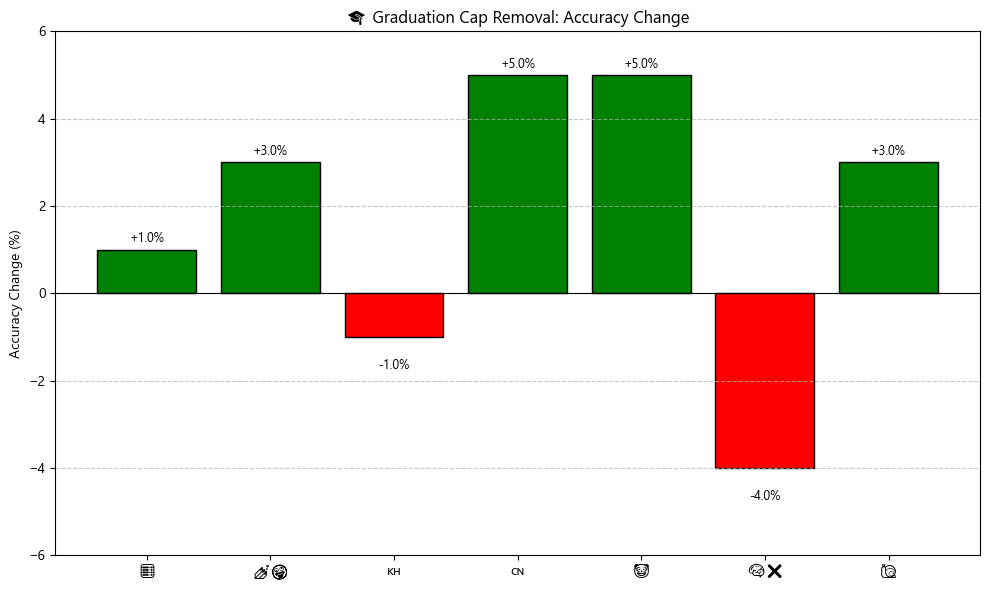

In [80]:
import matplotlib.pyplot as plt

# Make sure to set an emoji-compatible font
plt.rcParams['font.family'] = 'Segoe UI Emoji'  # Use 'Apple Color Emoji' on macOS or 'Noto Color Emoji' on Linux

# Data: (Label, With 🎓, Without 🎓)
data = [
    ("🧮", 45.00, 46.00),
    ("💅🤪", 48.00, 51.00),
    ("🇰🇭", 48.00, 47.00),
    ("🇨🇳", 44.00, 49.00),
    ("🤡", 46.00, 51.00),
    ("🧠❌", 53.00, 49.00),
    ("🐌", 44.00, 47.00),
]

labels = [label for (label, _, _) in data]
differences = [no_cap - with_cap for (_, with_cap, no_cap) in data]

# Colors for increase (green), decrease (red), no change (gray)
colors = ['green' if diff > 0 else 'red' if diff < 0 else 'gray' for diff in differences]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, differences, color=colors, edgecolor='black')

# Add annotations
for bar, diff in zip(bars, differences):
    sign = "+" if diff > 0 else ""
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if diff >= 0 else -0.5),
             f"{sign}{diff:.1f}%", ha='center', va='bottom' if diff >= 0 else 'top', fontsize=9)

# Chart formatting
plt.ylim(-6, 6)
plt.title("🎓 Graduation Cap Removal: Accuracy Change")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Accuracy Change (%)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
